# Ayuwoki Detector

## Preprocess images

Here I extract faces from raw images to create a training set of faces. The idea for the final program is to use the Haar cascade model to extract faces and then use my trained model to determine if it's an Ayuwoki or not.

I obtained the raw images using the [google-images-download](https://github.com/hardikvasa/google-images-download) package to download both ayuwoki and normal faces images. After that, I did some manual cleaning of the results, as they weren't perfect, but the library definitively made things faster. Once the images where in place in the `data/raw` directory, the work in this file starts.

In [ ]:
!pip install google_images_download;
!googleimagesdownload -k ayuwoki -o data/raw -i ayuwoki;
!googleimagesdownload -k person -o data/raw -i normal;


Item no.: 1 --> Item name = ayuwoki
Evaluating...
Starting Download...
Completed Image ====> 1. 1551733066-ayuwoki.jpg
Completed Image ====> 2. 1552474384_751735_1552474543_noticia_normal.jpg
Completed Image ====> 3. ayuwoki-7f3c991904989d201de583c0e0f10c95-1200x800.jpg
Completed Image ====> 4. ayuwoki-michael-jackson-meme-kzbe--620x349@abc.jpg
Completed Image ====> 5. ayuwoki-quien-es.jpg
Completed Image ====> 6. meme10-1552608250.png
Completed Image ====> 7. ayuwoky.jpg
Completed Image ====> 8. ayuwoki-demonio-ayuwoki-cabarer-ayuwoki-millenial-awo-rockero-ayuwakiinmortal-vwakn-dre-dicte-on-kocr-yuwoki-inmortal-ayuwoki-drogadicto-ayuwoki-influencer-ayuwoki-niga-0iso9.jpg
Completed Image ====> 9. que-y-quien-es-el-ayuwoki-de-los-memes.jpg
Completed Image ====> 10. noticia-1552683169-youtube-viral-tongo-ayuwoki.png
Completed Image ====> 11. 5427819319871173413994884016413640079966208n-b60439d6ce08e5bd8e943a860de44039-1200x600.jpg
Completed Image ====> 12. que-es-ayuwoki-challenge-2.jpg

# Face extraction

As the original images have more content thanjust the Ayuwoki or a normal face (backgrounds, text, etc.), I wanted to extract only the faces to make things easier for the model. For this, I'm using [OpenCV Face detection using Haar Cascades](https://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html). This is a [pre-trained model that you can find here](https://github.com/opencv/opencv/tree/master/data/haarcascades) in `xml` format. The class `cv2.CascadeClassifier` has a `detectMultiScale` method that returns a list with the `x` and `y` coordinates, as well as `w`idth and `h`eight of a rectangle containing the object you're looking for, in my case, a frontal face.

I'm not including the images in the repo to keep it lightweight, but basically you would need a `data/raw/normal` and a `data/raw/ayuwoki` folders with samples in them, and another pair of `data/clean/normal` and `data/clean/ayuwoki` folders empty, ready to receive only faces images.

In [379]:
from shutil import copyfile
import os
import cv2                
import matplotlib.pyplot as plt
from glob import glob
import numpy as np

face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

def extract_faces(files):
    
    croped_faces = []
        
    for file in files:
        try:
            img = cv2.imread(file)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray)

            for (x, y, w, h) in faces:
                croped_face = img[y:y+h, x:x+w]
                croped_faces.append(croped_face)
        
        except Exception as e:
            print('Failed extracting faces from file {}'.format(file))
            print(e)
    
    return croped_faces


def export_faces(raw_path, clean_path, valid_path=None):
    raw_files = np.array(glob("{}/*".format(raw_path)))
    
    i = 0
    faces = extract_faces(raw_files)
    print('There are {} faces in {}'.format(len(faces), raw_path))

    for face in faces:
        cv2.imwrite('{}/{}.jpg'.format(clean_path, i), face)
        i += 1
        
export_faces('data/raw/ayuwoki', 'data/clean/ayuwoki')
export_faces('data/raw/normal', 'data/clean/normal')

There are 8 faces
OpenCV(3.4.2) /opt/concourse/worker/volumes/live/9523d527-1b9e-48e0-7ed0-a36adde286f0/volume/opencv-suite_1535558719691/work/modules/imgproc/src/color.hpp:253: error: (-215:Assertion failed) VScn::contains(scn) && VDcn::contains(dcn) && VDepth::contains(depth) in function 'CvtHelper'

There are 182 faces


#### Ayuwoki sample

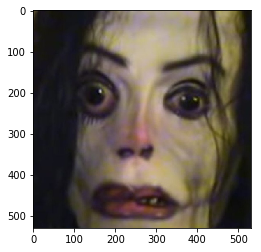

In [380]:
clean_ayuwoki_faces = np.array(glob("data/clean/ayuwoki/*"))

sample_ayuwoki = cv2.imread(clean_ayuwoki_faces[0])
rgb_ayuwoki = cv2.cvtColor(sample_ayuwoki, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_ayuwoki)

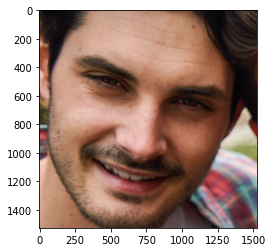

In [381]:
clean_normal_faces = np.array(glob("data/clean/normal/*"))

sample_normal = cv2.imread(clean_normal_faces[0])
rgb_normal = cv2.cvtColor(sample_normal, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_normal)

## Data augmentation

Ayuwoki images are kinda' the same. They have low variability, so I ended up using only a few images. This means that the classes will be very unbalanced. That's why I'm generating a lot of ayuwoki synthetic examples

In [382]:
from keras.preprocessing import image
from matplotlib import pyplot as plt

generator = image.ImageDataGenerator(
    rotation_range=45,
    horizontal_flip=True,
    fill_mode='nearest'
)

clean_ayuwoki_faces = np.array(glob("data/clean/ayuwoki/*"))
i = len(clean_ayuwoki_faces)

for img_path in clean_ayuwoki_faces:
    sample_img = image.load_img(img_path, target_size=(64, 64))
    x = image.img_to_array(sample_img)
    x = x.reshape((1, ) + x.shape)
    
    j = 0
    for batch in generator.flow(x, batch_size=1):

        mod_img = image.array_to_img(batch[0])
        mod_img_rgb = cv2.cvtColor(batch[0], cv2.COLOR_BGR2RGB)
        cv2.imwrite("data/clean/ayuwoki/{}_.jpg".format(i), mod_img_rgb)
        
        i += 1
        j += 1
    
        if j % 40 == 0:
            break
    
    if i >= len(clean_normal_faces):
        print('i is greater than # of normal images {}'.format(len(clean_normal_faces)))
        break

i is greater than # of normal images 182


## Model architecture and training

I'm using a Convolutional Neural Network, with max pooling and ending up with some fully connected layers. I'm using dropout for regularization and Stochastic Gradient Descent as the optimizer. The next cell prints out model architecture as well as training history.

In [450]:
from keras import models
from keras import layers
from keras import optimizers


model = models.Sequential()


model.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 3)))
model.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.4))

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.4))

model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
             optimizer=optimizers.SGD(lr=0.001, momentum=0.9),
             metrics=['acc'])

print(model.summary())

train_datagen = image.ImageDataGenerator(rescale=1./255, validation_split=0.7)

test_datagen = image.ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    'data/clean/',
    target_size=(64, 64),
    batch_size=100,
    class_mode='binary',
    subset='training'
)

valid_generator = train_datagen.flow_from_directory(
    'data/clean/',
    target_size=(64, 64),
    batch_size=100,
    class_mode='binary',
    subset='validation'
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=2,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=2
)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_311 (Conv2D)          (None, 64, 64, 16)        448       
_________________________________________________________________
conv2d_312 (Conv2D)          (None, 64, 64, 16)        2320      
_________________________________________________________________
max_pooling2d_221 (MaxPoolin (None, 32, 32, 16)        0         
_________________________________________________________________
flatten_70 (Flatten)         (None, 16384)             0         
_________________________________________________________________
dense_172 (Dense)            (None, 512)               8389120   
_________________________________________________________________
dropout_103 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_173 (Dense)            (None, 512)               262656    
__________

### Training & Validation Accuracy Evolution

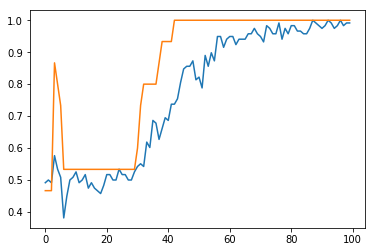

In [531]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(train_acc)
plt.plot(val_acc)

plt.show()

## Ayuwoki Detector

Now that I have trained my model, I want to create a function that takes in an image and returns the same image with a rectangle indicating where the Ayuwoki is.

I'll start with a function that returns a boolean indicating whether or not a face is an **ayuwoki face**.

In [534]:
def ayuwoki_face(face):
    x = image.img_to_array(face)
    x = x / 255
    x = x.reshape((1, ) + x.shape)

    prediction = model.predict(x)

    return prediction[0, 0] < 0.5


In [535]:
clean_normal_faces = np.array(glob("data/clean/normal/*"))
sample_normal_img = image.load_img(clean_normal_faces[20], target_size=(64, 64))
ayuwoki_face(sample_normal_img)

False

In [537]:
clean_ayuwoki_faces = np.array(glob("data/clean/ayuwoki/*"))
sample_ayuwoki_img = image.load_img(clean_ayuwoki_faces[20], target_size=(64, 64))
ayuwoki_face(sample_ayuwoki_img)

True

Now, I'll create the detection and marking function. It will return:

- A boolean indicating whether or not an ayuwoki  was detected
- The original image
- The croped image with the ayuwoki if it was detected, or `None` if not
- The (`x`, `y`, `w`, `h`) rectangle coordinates, where:
    - `x`: Top left corner x coordinate
    - `y`: Top left corner x coordinate
    - `w`: Width
    - `h`: Height

In [590]:
def detect_ayuwoki(img):
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    
    for (x, y, w, h) in faces:
        croped_face = img[y:y+h, x:x+w]
        croped_face = cv2.resize(croped_face, (64, 64))
        
        if ayuwoki_face(croped_face):
            return True, img, croped_face, (x, y, w, h)
    
    return False, img, None, (0, 0, 0, 0)

### Ayuwoki detector in action

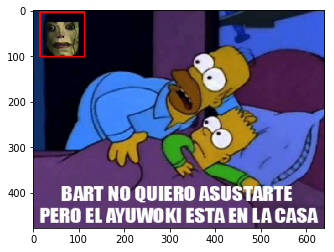

In [589]:
raw_ayuwoki_faces = np.array(glob("../../ayuwoki/downloads/ayuwoki/*"))

sample_ayuwoki_raw_img = cv2.imread(raw_ayuwoki_faces[25])
ayuwoki_detected, full_image, croped_image, (x, y, w, h) = detect_ayuwoki(sample_ayuwoki_raw_img)

if ayuwoki_detected:
    cv2.rectangle(full_image, (x,y), (x+w,y+h), (0,0,255), 2)
    cv_rgb = cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB)

    plt.imshow(cv_rgb)
    plt.show()